Pupose: apply affine transformation (rotation, scaling, shear), elastic deformation on an image and the corresponding mask slice, gamma correction on the image slice; visualize the outputs.

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
from augmentation import *
from db_modify_array import modify_array

In [2]:
## Load an image and the corresponding mask;
## Modify arrays: inputs dimensions must match the expected dimensions;
image = nib.load('example_image.nii.gz')
image = image.get_fdata() ## retrieve numpy array; output: 3D numpy array of size [H,W,N]
image = modify_array(image) ## output: 4D numpy array of size [N,1,H,W]
image = image / (3 * np.std(image)) ## normalize the data;

mask = nib.load('example_mask.nii.gz')
mask = mask.get_fdata()
mask = modify_array(mask)

## Choose a slice;
image_slice = image[10,0,:,:]
mask_slice = mask[10,0,:,:]

In [3]:
## Create Transform class object; pass a dictionary with initial transformation parameters;
## Transformation parameters are modified to perform one transformation at a time (see below);
ranges = {}
ranges['degree'] = 15
ranges['scale_yx'] = (1.,1.)
ranges['shear_yx'] = 0.0
ranges['sigma_points'] = (3,12)

transform = Transform()
transform.warp_mode = 'reflect'
transform.device_mode = None
transform.ranges = ranges
transform.dim = image.shape

In [4]:
## Rotation;
rotated_image, rotated_mask = transform.affine(image_slice, mask_slice)
deg = transform.parameters['degree'] ## Retrieve the value of the rotation angle in degrees;

## Scaling; specify scaling factors, set rotation degree to 0 (no rotation, no shear);
ranges['degree'] = 0
ranges['scale_yx'] = (0.9, 1.2)
scaled_image, scaled_mask = transform.affine(image_slice, mask_slice)
sy, sx = transform.parameters['scale_yx'] ## Retrieve scaling factors;

## Shear; specify shear factors, set scale factors to 1 (no rotation, no scaling);
ranges['scale_yx'] = (1.,1.)
ranges['shear_yx'] = 0.2
shear_image, shear_mask = transform.affine(image_slice, mask_slice)
shy, shx = transform.parameters['shear_yx'] ## Retrieve shear factors;

## Elastic deformation;
def_image, def_mask = transform.elastic(image_slice, mask_slice)

## Horizontal flip;
flipped_image, flipped_mask = transform.flip(image_slice, mask_slice)

## Gamma correction;
corr_image = transform.gamma_correction(image_slice)
power = transform.parameters['power'] ## Retrieve power factor;

## Resize arrays to compute histograms;
flatten = image_slice.flatten()
corr_flatten = corr_image.flatten()

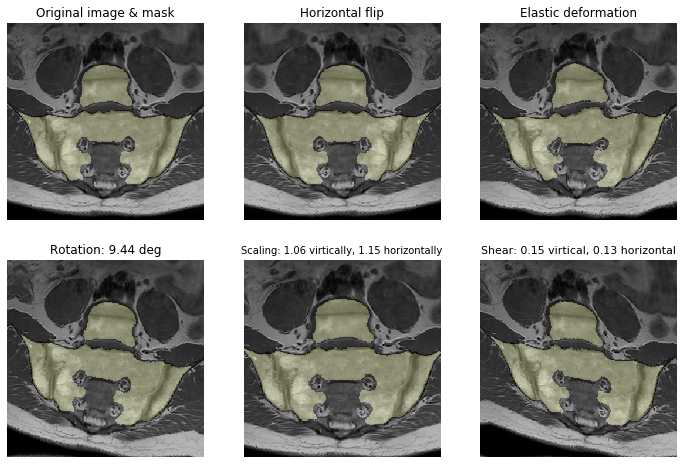

In [5]:
## Visualize the original and transformed image and mask slices;
plt.figure(figsize = (12,8))

## Super-imposed original image and mask slices;
plt.subplot(231)
plt.imshow(image_slice, cmap = 'gray')
plt.clim([0,1.4])
plt.imshow(mask_slice, cmap = 'inferno', alpha = 0.3)
plt.title('Original image & mask', fontsize = 12)
plt.axis('off')

## Super-imposed flipped image and mask slices;
plt.subplot(232)
plt.imshow(flipped_image, cmap = 'gray')
plt.clim([0,1.4])
plt.imshow(flipped_mask, cmap = 'inferno', alpha = 0.3)
plt.title('Horizontal flip', fontsize = 12)
plt.axis('off')

## Super-imposed elastically deformed image and mask slices;
plt.subplot(233)
plt.imshow(def_image, cmap = 'gray')
plt.clim([0,1.4])
plt.imshow(def_mask, cmap = 'inferno', alpha = 0.3)
plt.title('Elastic deformation', fontsize = 12)
plt.axis('off')

## Super-imposed rotated image and mask slices;
plt.subplot(234)
plt.imshow(rotated_image, cmap = 'gray')
plt.clim([0,1.4])
plt.imshow(rotated_mask, cmap = 'inferno', alpha = 0.3)
plt.title('Rotation: %s deg'%(np.round(deg,2)), fontsize = 12)
plt.axis('off')

## Super-imposed scaled image and mask slices;
plt.subplot(235)
plt.imshow(scaled_image, cmap = 'gray')
plt.clim([0,1.4])
plt.imshow(scaled_mask, cmap = 'inferno', alpha = 0.3)
plt.axis('off')
plt.title('Scaling: %s virtically, %s horizontally'%(np.round(sy,2),
                                                     np.round(sx,2)), fontsize = 10)

## Super-imposed shear image and mask slices;
plt.subplot(236)
plt.imshow(shear_image, cmap = 'gray')
plt.clim([0,1.4])
plt.imshow(shear_mask, cmap = 'inferno', alpha = 0.3)
plt.axis('off')
plt.title('Shear: %s virtical, %s horizontal'%(np.round(shy,2),
                                               np.round(shx,2)), fontsize = 11)

plt.show()

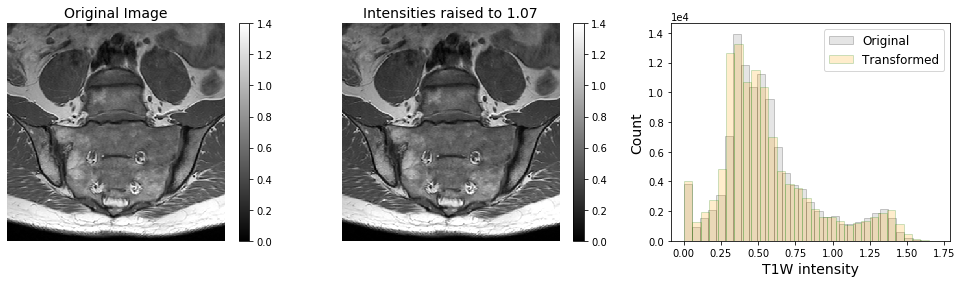

In [6]:
## Gamma correction;
plt.figure(figsize = (17,4))

## Original image slice;
plt.subplot(131)
plt.imshow(image_slice, cmap = 'gray')
plt.title('Original Image', fontsize = 14)
plt.clim([0,1.4])
plt.colorbar()
plt.axis('off')

## Modified image slice;
plt.subplot(132)
plt.imshow(corr_image, cmap = 'gray')
plt.title('Intensities raised to %s'%(np.round(power,2)), fontsize = 14)
plt.clim([0,1.4])
plt.colorbar()
plt.axis('off')

## Original and modified image slice histograms;
plt.subplot(133)
plt.hist(flatten, bins = 30, fc = 'gray', edgecolor = 'k', alpha = 0.2, label = 'Original')
plt.hist(corr_flatten, bins = 30, fc = 'orange', edgecolor = 'g', alpha = 0.2,
                                                                     label = 'Transformed')
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits=(0,0))
plt.xlabel('T1W intensity', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.legend(loc = 'upper right', fontsize = 12)

plt.show()